In [166]:
import math
import pandas as pd
import tensorflow as tf
# import keras_tuner.tuners as kt
import matplotlib.pyplot as plt
import keras
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError
import numpy as np
import pickle
np.random.seed(0)
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv1D, Conv2D, LeakyReLU, MaxPool1D, AveragePooling1D, UpSampling1D, Flatten, Dense, Reshape, BatchNormalization
# https://towardsdatascience.com/improve-your-model-performance-with-auto-encoders-d4ee543b4154
from tensorflow.keras import initializers
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from scipy.stats import multivariate_normal
from keras.optimizers import Adam, SGD, Adadelta

from keras.optimizers import Adam, SGD, Adadelta

In [167]:
x_train_scaled = pd.read_csv('../260_sample_train_scaled.csv').set_index("Patient_ID")
x_train_scaled.T

Patient_ID,55_control,168_CD_plain,72_control,120_control,258_CD_plain,254_CD_deep_ulcer,9_CD_plain,111_CD_plain,57_CD_plain,216_CD_deep_ulcer,...,303_CD_plain,35_control,148_CD_deep_ulcer,28_control,67_control,15_CD_plain,182_CD_plain,164_CD_plain,53_CD_plain,97_CD_plain
AADAC,0.702813,0.751408,0.786508,0.707491,0.701039,0.688952,0.626994,0.591800,0.776578,0.392511,...,0.781692,0.868755,0.820946,0.913545,0.935844,0.382762,0.679910,0.754656,0.591140,0.817125
APOA1,0.799052,0.603707,0.755331,0.662993,0.662511,0.790972,0.486913,0.677731,0.776586,0.306222,...,0.706428,0.777184,0.897985,0.873595,0.848575,0.384030,0.584723,0.556562,0.585802,0.782223
APOA4,0.719665,0.622768,0.739605,0.648072,0.707208,0.730387,0.686100,0.627623,0.817773,0.540222,...,0.762380,0.832517,0.934965,0.907560,0.854504,0.377332,0.722426,0.694062,0.750282,0.854442
APOB,0.729547,0.627712,0.756170,0.764621,0.834562,0.698611,0.568230,0.548575,0.688612,0.462697,...,0.824484,0.826357,0.816291,0.820765,0.864477,0.360165,0.643867,0.748334,0.753309,0.867360
APOC3,0.794953,0.606860,0.819875,0.654276,0.670160,0.814798,0.636292,0.670497,0.893823,0.430877,...,0.669462,0.724312,0.919488,0.852810,0.836009,0.300915,0.740014,0.535534,0.603372,0.793421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RSL24D1P1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MIEN1,0.543158,0.623796,0.853118,0.392582,0.259900,0.704568,0.376074,0.750395,0.793754,0.237463,...,0.238152,0.334790,1.000000,0.662575,0.543671,0.262892,0.413798,0.273699,0.183718,0.561414
PCBP1_AS1,0.622641,0.301179,0.431083,0.390569,0.431818,0.123324,0.241705,0.534881,0.439487,0.283500,...,0.366623,0.219109,0.539350,0.341922,0.391775,0.189790,0.270021,0.433093,0.302030,0.027077
LOC100133165,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [168]:
x_test_scaled = pd.read_csv('../260_sample_test_scaled.csv').set_index("Patient_ID")
x_test_scaled

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
Patient_ID,,,,,,,,,,,,,,,,,,,,,
253_CD_plain,0.869185,0.841880,0.930171,0.886737,0.835678,0.297964,0.668498,0.266670,0.278122,0.933520,...,0.339788,0.326732,0.0,0.862246,0.074473,0.0,0.498941,0.349920,0.0,0.0
105_CD_plain,0.853562,0.933532,0.942213,0.794578,0.890482,0.206529,0.298987,0.350745,0.495663,0.849038,...,0.354602,-0.031527,0.0,0.717305,0.039214,0.0,0.697073,0.268224,0.0,0.0
2_CD_plain,0.165531,0.141475,0.263684,0.198091,0.160503,0.888878,0.000000,0.134461,0.989132,0.202203,...,0.320002,0.379134,0.0,0.604202,0.610072,0.0,0.324065,0.375123,0.0,0.0
184_CD_plain,0.717121,0.660314,0.769417,0.752737,0.694874,0.514735,0.692365,0.271127,0.650742,0.694599,...,0.445680,0.178908,0.0,0.702114,0.325357,0.0,0.390919,0.185509,0.0,0.0
312_CD_plain,0.730072,0.722909,0.713076,0.743545,0.679258,0.308459,0.399235,0.129019,0.597529,0.720390,...,0.419254,0.312215,0.0,0.821584,0.632007,0.0,0.183158,0.271359,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107_CD_plain,0.736123,0.658232,0.772323,0.685637,0.658755,0.250970,0.247307,0.422075,0.555944,0.603675,...,0.379431,0.233196,0.0,0.759342,0.567491,0.0,0.404604,0.190411,0.0,0.0
279_CD_plain,0.220614,0.202090,0.182810,0.113245,0.105744,0.699851,0.000000,0.908485,0.688912,0.178259,...,0.181052,0.342262,0.0,0.639644,0.540444,0.0,0.397274,0.061934,0.0,0.0
179_CD_plain,0.724476,0.726774,0.766943,0.776284,0.690339,0.380637,0.440449,0.318944,0.558600,0.738787,...,0.331961,0.275577,0.0,0.886616,0.658049,0.0,0.259391,0.471132,0.0,0.0


## Full workflow

In [169]:
from numpy import inf
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler
from numpy import linalg as LA

### Calculate gene statistics

In [170]:
x_stats = x_test_scaled.describe().iloc[[1,2,3,-1]]

In [171]:
x_stats

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
mean,0.662326,0.615285,0.670829,0.658361,0.625205,0.459972,0.344742,0.345704,0.546377,0.595752,...,0.359887,0.248426,0.0,0.777372,0.440612,0.0,0.418557,0.331811,0.0,0.009305
std,0.186037,0.208824,0.196106,0.209957,0.200946,0.243852,0.282902,0.209450,0.221981,0.245207,...,0.106041,0.083038,0.0,0.129976,0.238418,0.0,0.197838,0.106248,0.0,0.082177
min,0.165531,0.141475,0.179189,0.041787,0.105744,0.000000,0.000000,0.000000,0.037820,0.077684,...,0.107633,-0.031527,0.0,0.323550,0.000000,0.0,0.048748,0.061934,0.0,0.000000
max,0.930585,1.029728,0.969910,0.950466,0.980092,1.151876,1.191519,0.915734,0.997430,1.042678,...,0.681479,0.404644,0.0,1.013531,1.221905,0.0,1.013627,0.701615,0.0,0.725770


In [172]:
gene_means = x_stats.iloc[0,:].values

In [173]:

gene_stds = x_stats.iloc[1,:].values

In [174]:
gene_vars = np.square(gene_stds)

### There are linear and non-linear relationships between gene features

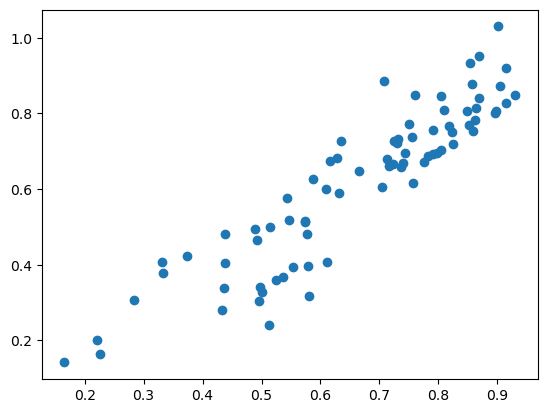

In [175]:
# positive correlation between AADAC and APOA1
data1 = x_test_scaled["AADAC"].values
data2 = x_test_scaled["APOA1"].values
plt.figure()
plt.scatter(data1, data2)
plt.show()

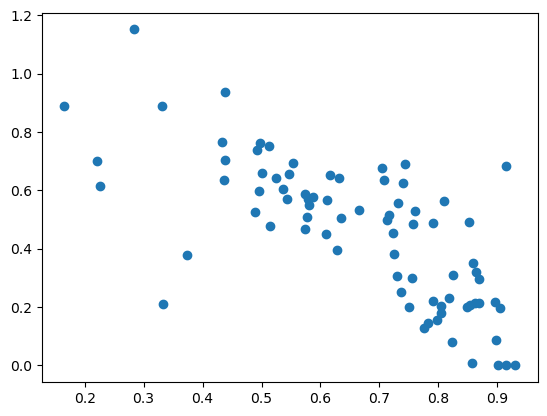

In [176]:
# negative correlation
data3 = x_test_scaled["AQP9"].values
plt.figure()
plt.scatter(data1, data3)
plt.show()

### Build covariance matrix

In [177]:
cov_matrix = np.cov(x_test_scaled.T)
cov_matrix

array([[ 0.0346099 ,  0.03545007,  0.03229206, ...,  0.00169059,
         0.        , -0.00118542],
       [ 0.03545007,  0.04360728,  0.03901119, ...,  0.00265384,
         0.        , -0.00234439],
       [ 0.03229206,  0.03901119,  0.03845744, ...,  0.00130892,
         0.        , -0.00167096],
       ...,
       [ 0.00169059,  0.00265384,  0.00130892, ...,  0.01128864,
         0.        ,  0.0009714 ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.00118542, -0.00234439, -0.00167096, ...,  0.0009714 ,
         0.        ,  0.0067531 ]])

In [178]:
n = x_test_scaled.shape[1]
cov_matrix.shape

(219, 219)

In [179]:
# scale down correlations?
# standard_scaler = MinMaxScaler((0,.1))
# cov_matrix = standard_scaler.fit_transform(cov)

In [180]:
for row in cov_matrix[:10]:
    print(row[:5])


[0.0346099  0.03545007 0.03229206 0.03665629 0.03308142]
[0.03545007 0.04360728 0.03901119 0.03912674 0.040442  ]
[0.03229206 0.03901119 0.03845744 0.03781809 0.03827751]
[0.03665629 0.03912674 0.03781809 0.04408185 0.03811898]
[0.03308142 0.040442   0.03827751 0.03811898 0.04037916]
[-0.03271326 -0.03465525 -0.02821937 -0.03357742 -0.02886588]
[0.03292607 0.03665677 0.03004513 0.0347112  0.03262496]
[-0.02327722 -0.02161166 -0.02121573 -0.02500798 -0.01986438]
[-0.03040691 -0.03275717 -0.02832788 -0.03291194 -0.0291266 ]
[0.04058488 0.04267114 0.03886446 0.04683968 0.03914626]


In [181]:
# diagonal currently covariance between each variable and itself
# set diagonal to variances
np.fill_diagonal(cov_matrix, gene_vars)


In [182]:
for row in cov_matrix[:10]:
    print(row[:5])

[0.0346099  0.03545007 0.03229206 0.03665629 0.03308142]
[0.03545007 0.04360728 0.03901119 0.03912674 0.040442  ]
[0.03229206 0.03901119 0.03845744 0.03781809 0.03827751]
[0.03665629 0.03912674 0.03781809 0.04408185 0.03811898]
[0.03308142 0.040442   0.03827751 0.03811898 0.04037916]
[-0.03271326 -0.03465525 -0.02821937 -0.03357742 -0.02886588]
[0.03292607 0.03665677 0.03004513 0.0347112  0.03262496]
[-0.02327722 -0.02161166 -0.02121573 -0.02500798 -0.01986438]
[-0.03040691 -0.03275717 -0.02832788 -0.03291194 -0.0291266 ]
[0.04058488 0.04267114 0.03886446 0.04683968 0.03914626]


### Processing - conditional genes & matrix adjustment

In [183]:
mod_gene_stds = gene_stds.copy()
mod_gene_means = gene_means.copy()


In [184]:
# if conditional genes, reset corresponding means
mod_gene_means[0] = 0.7
mod_gene_means[1] = 0.6


# then set 0 variances and stds
cond_gene_ids = [0,1]

def set_cond_vars(cond_gene_ids, cov_matrix, gene_stds):
    for idx in cond_gene_ids:
        cov_matrix[idx][idx] = 0.
        gene_stds[idx] = 0.
    return cov_matrix, gene_stds

cov_matrix, mod_gene_stds = set_cond_vars(cond_gene_ids, cov_matrix, mod_gene_stds)

In [185]:

# cond_cov_matrix[1:3,2:5] = 0
# cond_cov_matrix[2:5,1:3] = 0
for row in cov_matrix[:10]:
    print(row[:5])

[0.         0.03545007 0.03229206 0.03665629 0.03308142]
[0.03545007 0.         0.03901119 0.03912674 0.040442  ]
[0.03229206 0.03901119 0.03845744 0.03781809 0.03827751]
[0.03665629 0.03912674 0.03781809 0.04408185 0.03811898]
[0.03308142 0.040442   0.03827751 0.03811898 0.04037916]
[-0.03271326 -0.03465525 -0.02821937 -0.03357742 -0.02886588]
[0.03292607 0.03665677 0.03004513 0.0347112  0.03262496]
[-0.02327722 -0.02161166 -0.02121573 -0.02500798 -0.01986438]
[-0.03040691 -0.03275717 -0.02832788 -0.03291194 -0.0291266 ]
[0.04058488 0.04267114 0.03886446 0.04683968 0.03914626]


In [186]:
# cond_cov_matrix = cov_matrix.copy()

In [187]:
# adjust matrix to make it positive definite 
w, v = LA.eig(cov_matrix)
cond_cov_matrix = cov_matrix + (abs(np.min(w)) + 1e-7)*np.identity(n)

In [188]:
for row in cond_cov_matrix[:10]:
    print(row[:5])

[0.0411831  0.03545007 0.03229206 0.03665629 0.03308142]
[0.03545007 0.0411831  0.03901119 0.03912674 0.040442  ]
[0.03229206 0.03901119 0.07964054 0.03781809 0.03827751]
[0.03665629 0.03912674 0.03781809 0.08526495 0.03811898]
[0.03308142 0.040442   0.03827751 0.03811898 0.08156226]
[-0.03271326 -0.03465525 -0.02821937 -0.03357742 -0.02886588]
[0.03292607 0.03665677 0.03004513 0.0347112  0.03262496]
[-0.02327722 -0.02161166 -0.02121573 -0.02500798 -0.01986438]
[-0.03040691 -0.03275717 -0.02832788 -0.03291194 -0.0291266 ]
[0.04058488 0.04267114 0.03886446 0.04683968 0.03914626]


In [189]:
def get_patient_sample(means, cov_matrix, gene_stds, allow_singular=False):
    rv = multivariate_normal(means, cov_matrix, allow_singular=allow_singular)
    sample = rv.rvs(size=1, random_state=12) # sample gene expression for a dummy patient
    # account for rescaled variances when making cov matrix positive semidefinite
    rescaled_sample = (sample - means) * gene_stds + means
    return np.clip(rescaled_sample, 0, 1), np.clip(sample, 0, 1), rescaled_sample, sample

# patient_sample = get_patient_sample(mod_gene_means, cond_cov_matrix, mod_gene_stds)
rescaled_sample, sample, rescaled_sample_no_clip, sample_no_clip = get_patient_sample(mod_gene_means, cond_cov_matrix, mod_gene_stds)
patient_sample = rescaled_sample.copy()

In [190]:
# fig, ax = plt.subplots(1, 1)
# # ax.hist(gene_means, density=True, bins='auto', histtype='stepfilled', alpha=0.2, label='means')
# ax.hist(test_sample_no_clip, density=True, bins='auto', histtype='stepfilled', alpha=0.2, label='without_corr')
# ax.hist(sample_no_clip, density=True, bins='auto', histtype='stepfilled', alpha=0.2, label='with_corr')
# ax.hist(rescaled_sample_no_clip, density=True, bins='auto', histtype='stepfilled', alpha=0.2, label='with_corr_rescaled')


# # ax.hist(rescale, density=True, bins='auto', histtype='stepfilled', alpha=0.2)
# # ax.set_xlim(-20, 20)
# ax.legend(loc='best', frameon=False)
# plt.show()

In [191]:
patient_sample.min()

0.0

In [192]:
# ensure correct values set known genes
patient_sample[0] = 0.7
patient_sample[1] = 0.6

In [193]:
patient_sample

array([0.7       , 0.6       , 0.67644294, 0.703167  , 0.66372958,
       0.52031434, 0.39008364, 0.36137854, 0.60097939, 0.42272118,
       0.4488547 , 0.35381929, 0.22942742, 0.65123151, 0.62585015,
       0.61284347, 0.48566773, 0.52189465, 0.62710191, 0.56451986,
       0.5662682 , 0.65090427, 0.51467691, 0.39614737, 0.4642568 ,
       0.55377191, 0.60647986, 0.60231411, 0.68941566, 0.61588158,
       0.53368654, 0.4986537 , 0.32627273, 0.58420161, 0.47905936,
       0.43231761, 0.40675723, 0.59997471, 0.46403911, 0.60001896,
       0.59366231, 0.46337038, 0.59165904, 0.51231123, 0.6110422 ,
       0.69684446, 0.42573114, 0.52966474, 0.70660275, 0.44339491,
       0.53755999, 0.25126869, 0.4958117 , 0.43736484, 0.45946703,
       0.49226086, 0.47623344, 0.72418541, 0.53563191, 0.75112021,
       0.58008248, 0.4710363 , 0.53035337, 0.49957987, 0.53103263,
       0.44185395, 0.6260219 , 0.58543626, 0.40746923, 0.66262818,
       0.54308082, 0.37428615, 0.5289482 , 0.62561551, 0.55213

In [194]:
# test_sample using only variance, no correlations
test_cov = np.zeros((n,n))
np.fill_diagonal(test_cov, gene_vars) 

rv_test = multivariate_normal(gene_means, test_cov, allow_singular=True)
test_sample = np.clip(rv_test.rvs(size=1, random_state=None), 0, 1)
test_sample_no_clip = rv_test.rvs(size=1, random_state=None)

# set known values
test_sample[0] = 0.7
test_sample[1] = 0.6

In [195]:
# np.round(test_sample, 3)

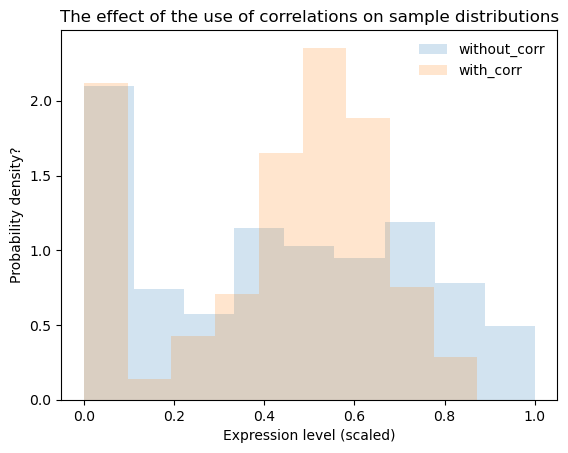

In [196]:
fig, ax = plt.subplots(1, 1)
# ax.hist(gene_means, density=True, bins='auto', histtype='stepfilled', alpha=0.2, label='means')
ax.hist(test_sample, density=True, bins='auto', histtype='stepfilled', alpha=0.2, label='without_corr')
ax.hist(patient_sample, density=True, bins='auto', histtype='stepfilled', alpha=0.2, label="with_corr")
# ax.hist(sample, density=True, bins='auto', histtype='stepfilled', alpha=0.2, label="with_corr")
# ax.hist(rescaled_sample, density=True, bins='auto', histtype='stepfilled', alpha=0.2, label='with_corr_rescaled')
ax.set_title("The effect of the use of correlations on sample distributions")
ax.set_xlabel("Expression level (scaled)")
ax.set_ylabel("Probability density?")


# ax.hist(rescale, density=True, bins='auto', histtype='stepfilled', alpha=0.2)
# ax.set_xlim(-20, 20)
ax.legend(loc='best', frameon=False)
plt.show()

## Calculate SHAP values

In [197]:
shap_values[0].shape

NameError: name 'shap_values' is not defined

In [ ]:
shap_values = explainer.shap_values(X=x_test_scaled[:2])

In [ ]:
shap_values

## Save SHAP values

In [ ]:
# with open("shap_values", "wb") as fp:   #Pickling
#     pickle.dump(shap_values, fp)

In [ ]:


with open("../shap_values", "rb") as fp:   # Unpickling
    shap_values = pickle.load(fp)

In [ ]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')